# CS145: Project 2 | Project Name

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Albert Hwang, albertjh*

# Project Overview

---
## Central Question

The core objective of this project is to address the question: "How can San Francisco's transit systems best suit the needs of its residents?" This central question aims to explore and identify strategies for understanding the bikeshare system, when it's most commonly used, and the routes most frequented. The goal is to provide actionable insights that can inform the expansion of public transit on popular routes or modification of the bikeshare network to better serve the community.

## Supplementary Questions

To comprehensively address the central question, several supplementary questions will be explored:

* Usage Patterns Analysis: What are the peak usage times and most frequented routes in the bikeshare system? Understanding these patterns can help in identifying areas with high demand.
* Station Efficiency Evaluation: Which stations are most and least utilized? Are there stations that consistently experience bike shortages or surpluses?
* Integration with Public Transport: How well integrated is the bikeshare system with other modes of public transportation? Can strategic placement near transit hubs improve accessibility? (this will be more qualitative analysis)

These supplementary questions are designed to provide a multi-dimensional analysis of the bikeshare system, offering insights that contribute to answering the central question. By exploring these queries, the project aims to deliver a well-rounded understanding of the current state of the bikeshare system and propose data-driven recommendations for its optimization.

---


# Analysis of Dataset

---
## Dataset Summary
The `san_francisco_bikeshare` dataset consists of four main tables:

1. `bikeshare_regions`: outlines the different bikeshare regions, providing a macro view of the service's geographical footprint. Analyzing this data can reveal insights into the spread and regional penetration of bike-sharing services across San Francisco.
2. `bikeshare_station_info`: contains detailed information about each bikeshare station, such as its location, installation date, and capacity. This table is integral to understanding the physical infrastructure of the bikeshare network, including how evenly spread the stations are, whether their capacities align with demand, and how the network has grown or changed over time.
3. `bikeshare_station_status`: records data like the number of available bikes and docks at different times. Such information is crucial for assessing the real-time utilization of stations and identifying patterns or trends in station usage.
4. `bikeshare_trips`: logs individual bike trips, capturing data on trip duration, start and end times, and the stations involved. This table allows for a deep dive into user behavior, popular routes, peak usage times, and overall system efficiency.

It is roughly 366MB in size.

## Dataset Organization and Relationships

1. Inter-Table Relationships: The tables are interconnected, with bikeshare_trips linking to bikeshare_station_info through station IDs. This connection is key to understanding trip patterns in relation to specific station characteristics. There are complications with this, however (see Data Exploration).
2. Keys and Foreign Keys: Station IDs serve as a primary key in bikeshare_station_info and as foreign keys in bikeshare_trips and bikeshare_station_status. This linkage will help me join tables and conduct comprehensive analyses.
3. Data Consistency and Limitations: There are several limitations with this data. For one, the station_id between bikeshare_trips and bikeshare_station_info do not always match. This seems to be an issue on bikeshare_trips, as some duplicate station names seem arbitrarily created, sometimes omitting one or more characters but otherwise being substantially the same. For example, the Ferry Building is appears as both "San Francisco Ferry Building (Harry Bridges Plaza)" and "Harry Bridges Plaza (Ferry Building)". In the examples below, you can see that there are further discrepancies between ID and name.

The best workaround I have found for this issue is to only consider data from 2017 onwards. Before this point, nothing was in sync between the two tables. With this time constraint, I will assume that station_ids are the same between both tables (see justification below). While this doesn't produce the most accurate, real-world results, it is an unfortunate necessity to overcome a flaw of this dataset that cannot be trivially worked around.

These 4 queries join bikeshare_station_info and bikeshare_trips based on ID in order to properly identify extraneously listed stations.


Below shows the amount of stations that match ID with station_info across the entire trips table (notice 264).

In [ ]:
%%bigquery --project $project_id
SELECT DISTINCT
  CAST(info.station_id AS INT64) AS station_id,
  info.name AS station_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
ON CAST(info.station_id AS INT64) = trips.start_station_id
WHERE info.name = trips.start_station_name

UNION DISTINCT

SELECT DISTINCT
  CAST(info.station_id AS INT64) AS station_id,
  info.name AS station_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
ON CAST(info.station_id AS INT64) = trips.end_station_id
WHERE info.name = trips.end_station_name


Query is running:   0%|          |

Downloading:   0%|          |

,station_id,station_name
0,198,Snow Park
1,212,Mosswood Park
2,46,San Antonio Park
3,195,Bay Pl at Vernon St
4,211,Broadway at 40th St
...,...,...
259,301,Willow St at Vine St
260,256,Hearst Ave at Euclid Ave
261,300,Palm St at Willow St
262,303,San Pedro St at Hedding St


Below shows instances of matching station_id but mismatching names. Note 92 rows, and how some of the names are complete mismatches that are not remotely close to each other. Others still, as is visible on rows 90 and 91, are simply missing a character.

In [ ]:
%%bigquery --project $project_id
SELECT DISTINCT
  CAST(info.station_id AS INT64) AS station_id,
  info.name AS station_info_name,
  trips.start_station_name AS trip_start_station_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
ON CAST(info.station_id AS INT64) = trips.start_station_id
WHERE info.name != trips.start_station_name

UNION DISTINCT

SELECT DISTINCT
  CAST(info.station_id AS INT64) AS station_id,
  info.name AS station_info_name,
  trips.end_station_name AS trip_end_station_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
ON CAST(info.station_id AS INT64) = trips.end_station_id
WHERE info.name != trips.end_station_name


Query is running:   0%|          |

Downloading:   0%|          |

,station_id,station_info_name,trip_start_station_name
0,23,The Embarcadero at Steuart St,San Mateo County Center
1,22,Howard St at Beale St,Redwood City Caltrain Station
2,9,Broadway at Battery St,Japantown
3,11,Davis St at Jackson St,MLK Library
4,84,Duboce Park,Ryland Park
...,...,...,...
87,25,Howard St at 2nd St,Stanford in Redwood City
88,26,1st St at Folsom St,Redwood City Medical Center
89,30,San Francisco Caltrain (Townsend St at 4th St),Middlefield Light Rail Station
90,88,11th St at Bryant St,5th S at E. San Salvador St


This is the same as the first query, but limiting from 2017 onwards. Notice how the number of matches is the same at 264.

In [ ]:
%%bigquery --project $project_id
-- Matches in Start Station Names from 2017 Onwards
SELECT DISTINCT
  CAST(info.station_id AS INT64) AS station_id,
  info.name AS station_info_name,
  trips.start_station_name AS trip_start_station_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
ON CAST(info.station_id AS INT64) = trips.start_station_id
WHERE info.name = trips.start_station_name
  AND EXTRACT(YEAR FROM trips.start_date) >= 2017

UNION DISTINCT

-- Matches in End Station Names from 2017 Onwards
SELECT DISTINCT
  CAST(info.station_id AS INT64) AS station_id,
  info.name AS station_info_name,
  trips.end_station_name AS trip_end_station_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
ON CAST(info.station_id AS INT64) = trips.end_station_id
WHERE info.name = trips.end_station_name
  AND EXTRACT(YEAR FROM trips.start_date) >= 2017


Query is running:   0%|          |

Downloading:   0%|          |

,station_id,station_info_name,trip_start_station_name
0,198,Snow Park,Snow Park
1,212,Mosswood Park,Mosswood Park
2,195,Bay Pl at Vernon St,Bay Pl at Vernon St
3,178,Broadway at 30th St,Broadway at 30th St
4,211,Broadway at 40th St,Broadway at 40th St
...,...,...,...
259,225,23rd Ave at Foothill Blvd,23rd Ave at Foothill Blvd
260,283,Delmas Ave and San Fernando St,Delmas Ave and San Fernando St
261,299,Bestor Art Park,Bestor Art Park
262,271,San Pablo Park,San Pablo Park


This applies the same principle, but for mismatches. Notice how there are now only 21, and that the mismatched names are clerical errors and swapped street names (with a few exceptions). Because of this, it is relatively safe to assume that the dataset is clean starting from 2017.

In [ ]:
%%bigquery --project $project_id
-- Mismatches in Start Station Names from 2017 Onwards
SELECT DISTINCT
  CAST(info.station_id AS INT64) AS station_id,
  info.name AS station_info_name,
  trips.start_station_name AS trip_start_station_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
ON CAST(info.station_id AS INT64) = trips.start_station_id
WHERE info.name != trips.start_station_name
  AND EXTRACT(YEAR FROM trips.start_date) >= 2017

UNION DISTINCT

-- Mismatches in End Station Names from 2017 Onwards
SELECT DISTINCT
  CAST(info.station_id AS INT64) AS station_id,
  info.name AS station_info_name,
  trips.end_station_name AS trip_end_station_name
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
ON CAST(info.station_id AS INT64) = trips.end_station_id
WHERE info.name != trips.end_station_name
  AND EXTRACT(YEAR FROM trips.start_date) >= 2017


Query is running:   0%|          |

Downloading:   0%|          |

,station_id,station_info_name,trip_start_station_name
0,321,Folsom St at 5th St,5th at Folsom
1,233,4th Ave at E 12th St (Temporary Location),12th St at 4th Ave
2,221,6th Ave at E 12th St (Temporary Location),12th St at 6th Ave
3,323,Broadway at Kearny St,Broadway at Kearny
4,282,E Virginia St at S 2nd St,Market St at Park St
5,131,22nd St at Dolores St,Dolores St at 22nd St
6,281,9th St at San Fernando St,9th St at San Fernando
7,280,San Fernando St at 7th St,San Fernando at 7th St
8,174,52nd St at MLK Jr Way,Shattuck Ave at 51st St
9,16,Market St at Steuart St,Steuart St at Market St


# Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs-145-project-test"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Installation and import
#!pip install -U plotly
#!pip install seaborn
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from urllib.request import urlopen
import json
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

## Analysis of Temporal Usage Patterns

First, we will examine usage patterns on a weekday vs weekend basis. Note for this section, we are just finding trends in the data related to time, so station location is quite irrelevant. Thus, we will be using the entire trips table.

In [ ]:
weekday_vs_weekend_query = """
SELECT
  EXTRACT(DAYOFWEEK FROM start_date) AS day_of_week,
  COUNT(*) AS number_of_trips
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY day_of_week
ORDER BY day_of_week;
"""

weekday_vs_weekend_df = client.query(weekday_vs_weekend_query).to_dataframe()

In [ ]:
day_of_week_mapping = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

# Map the day of week numbers to names
weekday_vs_weekend_df['day_of_week_name'] = weekday_vs_weekend_df['day_of_week'].map(day_of_week_mapping)


fig = px.bar(
    weekday_vs_weekend_df,
    x='day_of_week_name',
    y='number_of_trips',
    text='number_of_trips'
)

fig.update_layout(
    title='Bikeshare Usage: Weekday vs Weekend',
    xaxis_title='Day of Week',
    yaxis_title='Number of Trips'
)

fig.show()


As shown, usage is significantly higher on weekdays than weekends. This likely implies that these bikes are used as a form of work commute. Let's further support that hypothesis by looking at the start times of trips on the weekdays.

In [ ]:
start_times_query = """
SELECT
    CASE
        WHEN EXTRACT(HOUR FROM start_date) BETWEEN 5 AND 9 THEN 'Early Morning (05:00-10:00)'
        WHEN EXTRACT(HOUR FROM start_date) BETWEEN 10 AND 11 THEN 'Late Morning (10:00-12:00)'
        WHEN EXTRACT(HOUR FROM start_date) BETWEEN 12 AND 14 THEN 'Early Afternoon (12:00-15:00)'
        WHEN EXTRACT(HOUR FROM start_date) BETWEEN 15 AND 16 THEN 'Late Afternoon (15:00-17:00)'
        WHEN EXTRACT(HOUR FROM start_date) BETWEEN 17 AND 19 THEN 'Early Evening (17:00-20:00)'
        WHEN EXTRACT(HOUR FROM start_date) BETWEEN 20 AND 23 THEN 'Late Evening (20:00-00:00)'
        ELSE 'After Hours (00:00-05:00)'
    END AS time_interval,
    COUNT(*) AS number_of_trips
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
WHERE EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7) -- Excluding Sunday (1) and Saturday (7)
GROUP BY time_interval
ORDER BY number_of_trips DESC;
"""
start_times_df = client.query(start_times_query).to_dataframe()

In [ ]:
fig = px.bar(
    start_times_df,
    x='number_of_trips',
    y='time_interval',
    text='number_of_trips',
    color='number_of_trips',
)

fig.update_layout(
    title='Bike Trips by Time Interval',
    yaxis_title='Time Interval',
    xaxis_title='Number of Trips',
    yaxis=dict(autorange="reversed")
)

fig.show()

From this data, it's clear that the vast majority of weekday trips are done during peak commute hours of the early morning and early evening. We can explore further by finding out which routes are most popular during these times (in the next section).

Let's also examine the most popular months for bike usage.

In [ ]:
seasonal_pattern_query = """
SELECT
  EXTRACT(MONTH FROM start_date) AS month,
  COUNT(*) AS number_of_trips
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
GROUP BY month
ORDER BY month;
"""

seasonal_pattern_df = client.query(seasonal_pattern_query).to_dataframe()

In [ ]:
fig = px.bar(seasonal_pattern_df, x='month', y='number_of_trips', title='Seasonal Bike Usage Patterns')
fig.show()

## Commonly-used Routes and Stations

For starters, let's find the top 10 most common start and end stations. Starting from this section, with anything related to identifying stations, we will be limiting our data from 2017 onwards.

In [ ]:
frequent_starts_query = """
SELECT
  info.name AS start_station_name,
  info.station_id AS start_station_id,
  COUNT(*) AS number_of_starts,
  info.lat AS latitude,
  info.lon AS longitude
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
ON trips.start_station_id = CAST(info.station_id AS INT64)
WHERE EXTRACT(YEAR FROM trips.start_date) >= 2017
GROUP BY info.name, info.station_id, info.lat, info.lon
ORDER BY number_of_starts DESC
LIMIT 15;
"""
frequent_starts_df = client.query(frequent_starts_query).to_dataframe()


frequent_ends_query = """
SELECT
  info.name AS end_station_name,
  info.station_id AS end_station_id,
  COUNT(*) AS number_of_ends,
  info.lat AS latitude,
  info.lon AS longitude
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` info
ON trips.end_station_id = CAST(info.station_id AS INT64)
WHERE EXTRACT(YEAR FROM trips.start_date) >= 2017
GROUP BY info.name, info.station_id, info.lat, info.lon
ORDER BY number_of_ends DESC
LIMIT 15;
"""
frequent_ends_df = client.query(frequent_ends_query).to_dataframe()

In [ ]:
fig_start = go.Figure(go.Bar(
    x=frequent_starts_df['number_of_starts'],
    y=frequent_starts_df['start_station_name'],
    orientation='h',
    marker_color='skyblue'
))

fig_start.update_layout(
    title='Most Frequent Start Points',
    xaxis_title='Number of Starts',
    yaxis_title='Start Station Name',
    yaxis=dict(autorange="reversed")
)

fig_end = go.Figure(go.Bar(
    x=frequent_ends_df['number_of_ends'],
    y=frequent_ends_df['end_station_name'],
    orientation='h',
    marker_color='salmon'
))

fig_end.update_layout(
    title='Most Frequent End Points',
    xaxis_title='Number of Ends',
    yaxis_title='End Station Name',
    yaxis=dict(autorange="reversed")
)

fig_start.show()
fig_end.show()

In [ ]:
size_starts = frequent_starts_df['number_of_starts'].tolist()
size_ends = frequent_ends_df['number_of_ends'].tolist()

fig_start = px.scatter_mapbox(
    frequent_starts_df,
    lat="latitude",
    lon="longitude",
    size=size_starts,
    color="number_of_starts",
    color_continuous_scale=px.colors.diverging.RdYlBu,
    hover_name="start_station_name",
    title="Top 15 Frequent Start Stations",
    zoom=12
)

fig_start.update_layout(mapbox_style="open-street-map")
fig_start.show()

fig_end = px.scatter_mapbox(
    frequent_ends_df,
    lat="latitude",
    lon="longitude",
    size=size_ends,
    color="number_of_ends",
    color_continuous_scale=px.colors.diverging.RdYlBu,
    hover_name="end_station_name",
    title="Top 15 Frequent End Stations",
    zoom=12
)

fig_end.update_layout(mapbox_style="open-street-map")
fig_end.show()

While this data is useful (for instance, it confirms that commute seems to be a major factor in bikesharing -- look to major transit hubs in Caltrain and the Ferry Building), it doesn't tell us much about whether the relationship between these points: how many trips are actually done with these stations as termini? To determine this, let's query the station pairs of these trips to determine the most common routes, and then represent the relationship between the most popular stations with a heatmap.

In [139]:
common_pairs_query = """
SELECT
    start_info.name AS start_station_name,
    end_info.name AS end_station_name,
    COUNT(*) AS number_of_trips
FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
JOIN
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` start_info
ON
    CAST(trips.start_station_id AS STRING) = start_info.station_id
JOIN
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` end_info
ON
    CAST(trips.end_station_id AS STRING) = end_info.station_id
WHERE
    EXTRACT(YEAR FROM trips.start_date) >= 2017
GROUP BY
    start_station_name, end_station_name
ORDER BY
    number_of_trips DESC
"""
common_pairs_df = client.query(common_pairs_query).to_dataframe()

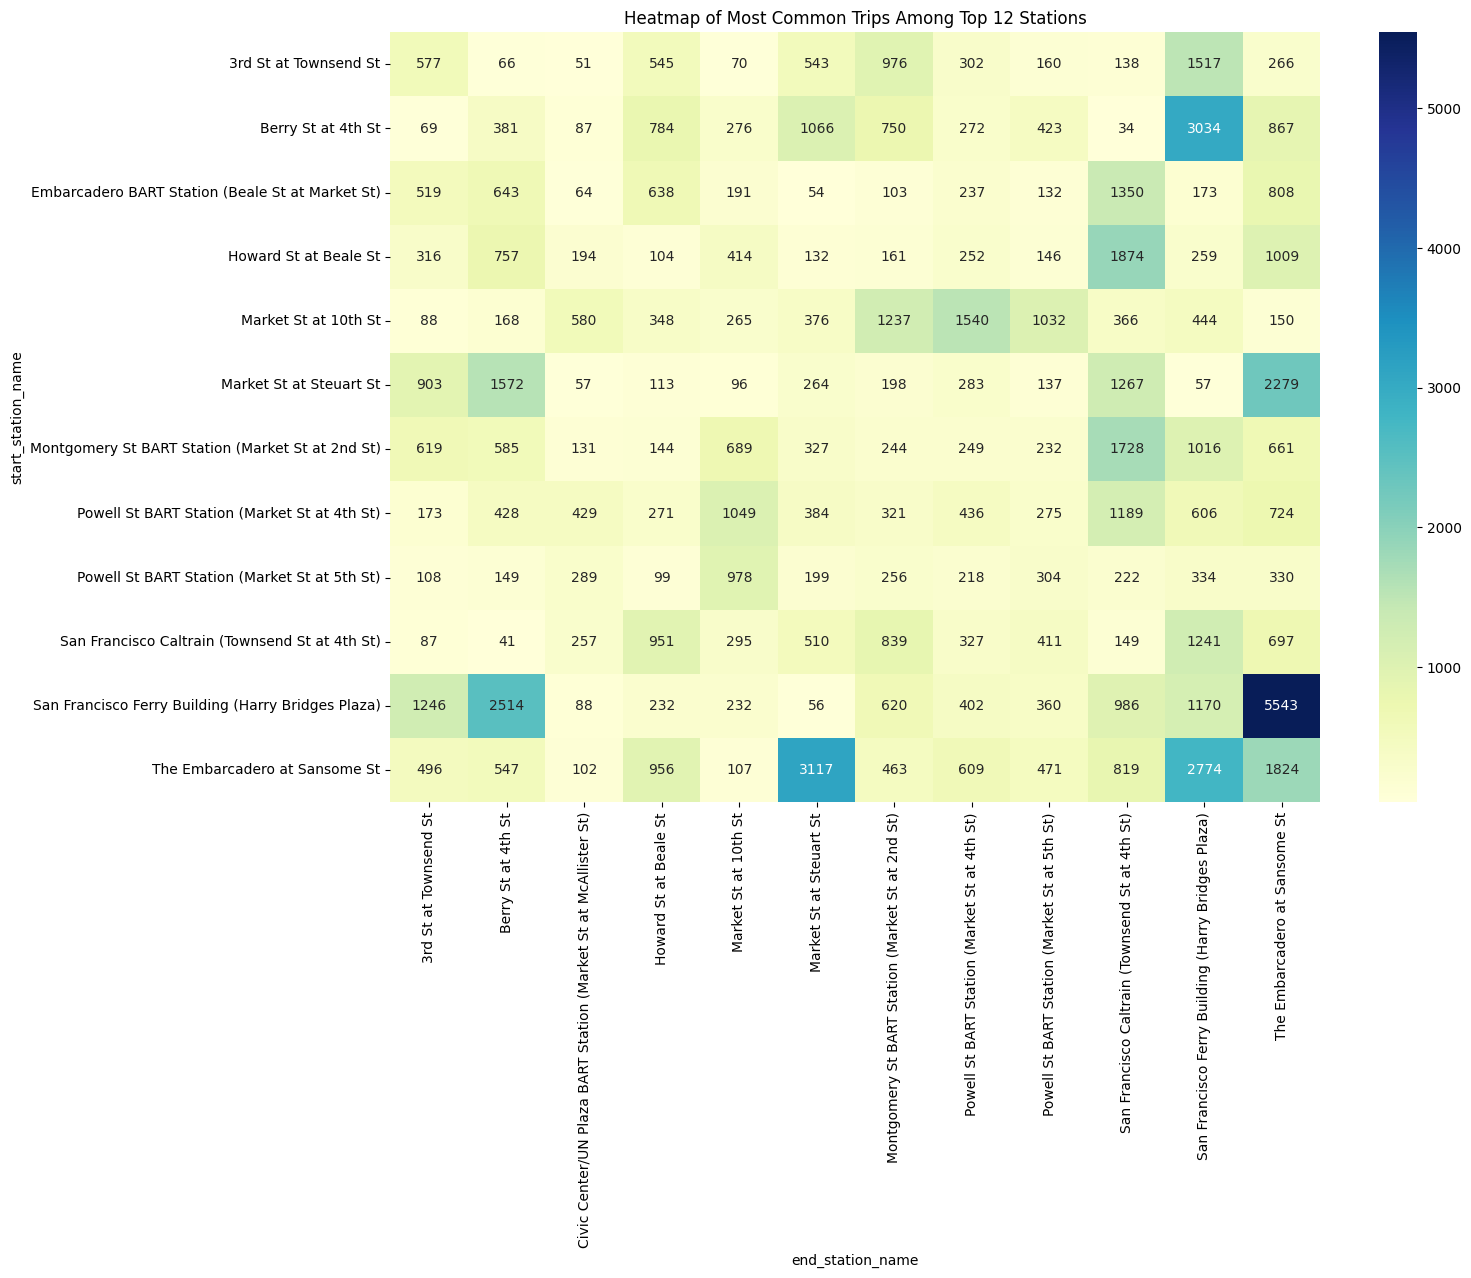

In [140]:
# Find the top 12 start and end stations
top_starts = common_pairs_df.groupby('start_station_name')['number_of_trips'].sum().nlargest(12).index
top_ends = common_pairs_df.groupby('end_station_name')['number_of_trips'].sum().nlargest(12).index

filtered_trips_df = common_pairs_df[common_pairs_df['start_station_name'].isin(top_starts) & common_pairs_df['end_station_name'].isin(top_ends)]

heatmap_data = filtered_trips_df.pivot_table(index='start_station_name', columns='end_station_name', values='number_of_trips', aggfunc='sum', fill_value=0)

# Replace NaN values with 0 (assuming NaN means no trips for that station pair)
heatmap_data = heatmap_data.fillna(0)
heatmap_data = heatmap_data.astype(float)

plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap of Most Common Trips Among Top 12 Stations")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [142]:
top_pairs_df = common_pairs_df.head(10)

top_pairs_df['route'] = top_pairs_df['start_station_name'] + " to " + top_pairs_df['end_station_name']

fig = px.bar(
    top_pairs_df,
    x='number_of_trips',
    y='route',
    orientation='h',
    text='number_of_trips',
)

fig.update_layout(
    title='Most Common Routes',
    xaxis_title='Number of Trips',
    yaxis_title='Route',
    yaxis=dict(autorange="reversed")
)

fig.show()

<ipython-input-142-332ec8749487>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Here we can see the most popular routes, which can give us insight into how we can develop infrastructure and services to meet demand.

## Putting it All Together

We can combine our observations of common time and space, starting off with a representation of the most common weekday and weekend routes.

In [ ]:
weekday_routes_query = """
SELECT
    start_info.name AS start_station_name,
    end_info.name AS end_station_name,
    COUNT(*) AS total_trips
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` start_info
ON CAST(trips.start_station_id AS STRING) = start_info.station_id
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` end_info
ON CAST(trips.end_station_id AS STRING) = end_info.station_id
WHERE EXTRACT(DAYOFWEEK FROM trips.start_date) IN (1, 7) -- Weekend
GROUP BY start_station_name, end_station_name
ORDER BY total_trips DESC
LIMIT 10;
"""
weekday_routes_df = client.query(weekday_routes_query).to_dataframe()

weekend_routes_query = """
SELECT
    start_info.name AS start_station_name,
    end_info.name AS end_station_name,
    COUNT(*) AS total_trips
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` start_info
ON CAST(trips.start_station_id AS STRING)= start_info.station_id
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` end_info
ON CAST(trips.end_station_id AS STRING)= end_info.station_id
WHERE EXTRACT(DAYOFWEEK FROM trips.start_date) BETWEEN 2 AND 6 -- Weekday
GROUP BY start_station_name, end_station_name
ORDER BY total_trips DESC
LIMIT 10;
"""
weekend_routes_df = client.query(weekend_routes_query).to_dataframe()


In [ ]:
weekday_routes_df['route'] = weekday_routes_df['start_station_name'] + " to " + weekday_routes_df['end_station_name']

fig_weekday = px.bar(
    weekday_routes_df,
    x='total_trips',
    y='route',
    orientation='h',
    title='Top 10 Popular Weekday Routes',
    labels={'total_trips': 'Total Trips', 'y': 'Route'}
)

fig_weekday.update_layout(xaxis_title='Total Number of Trips', yaxis_title='Route', yaxis=dict(autorange="reversed"))
fig_weekday.show()


weekend_routes_df['route'] = weekend_routes_df['start_station_name'] + " to " + weekend_routes_df['end_station_name']

fig_weekend = px.bar(
    weekend_routes_df,
    x='total_trips',
    y='route',
    orientation='h',
    title='Top 10 Popular Weekend Routes',
    labels={'total_trips': 'Total Trips', 'y': 'Route'}
)

fig_weekend.update_layout(xaxis_title='Total Number of Trips', yaxis_title='Route', yaxis=dict(autorange="reversed"))
fig_weekend.show()


Now, continuing off of our analysis of temporal usage patterns, let's see which routes are most commonly used during peak commute hours of the weekdays.

This comprehensive query finds the most common routes in the peak commute intervals. It contains data such as counts of when routes were done (morning or evening) and length of the routes (as the crow flies) by computing the distance between coordinates.

In [ ]:
popular_weekday_commute_routes_query = """
WITH TripsWithTime AS (
    SELECT
        CAST(start_station_id AS STRING) AS start_station_id,
        CAST(end_station_id AS STRING) AS end_station_id,
        EXTRACT(HOUR FROM start_date) AS start_hour,
        EXTRACT(DAYOFWEEK FROM start_date) AS day_of_week
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE EXTRACT(YEAR FROM start_date) >= 2017 -- Only from 2017 onwards
      AND EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 2 AND 6 -- Weekdays
      AND (EXTRACT(HOUR FROM start_date) BETWEEN 5 AND 9 -- Early Morning
           OR EXTRACT(HOUR FROM start_date) BETWEEN 17 AND 19) -- Early Evening
), CommonRoutes AS (
    SELECT
        start_station_id,
        end_station_id,
        SUM(CASE WHEN start_hour BETWEEN 5 AND 9 THEN 1 ELSE 0 END) AS morning_trips,
        SUM(CASE WHEN start_hour BETWEEN 17 AND 19 THEN 1 ELSE 0 END) AS evening_trips,
        COUNT(*) AS total_trips
    FROM TripsWithTime
    GROUP BY start_station_id, end_station_id
), StationCoordinates AS (
    SELECT
        station_id,
        name,
        lat,
        lon
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info`
)
SELECT
    S1.name AS start_station_name,
    S2.name AS end_station_name,
    CR.start_station_id,
    CR.end_station_id,
    S1.lat AS start_latitude,
    S1.lon AS start_longitude,
    S2.lat AS end_latitude,
    S2.lon AS end_longitude,
    CR.morning_trips,
    CR.evening_trips,
    CR.total_trips,
    ST_DISTANCE(ST_GEOGPOINT(S1.lon, S1.lat), ST_GEOGPOINT(S2.lon, S2.lat)) AS distance_meters
FROM
    CommonRoutes CR
JOIN
    StationCoordinates S1 ON CR.start_station_id = S1.station_id
JOIN
    StationCoordinates S2 ON CR.end_station_id = S2.station_id
ORDER BY
    total_trips DESC
"""
popular_weekday_commute_routes_df = client.query(popular_weekday_commute_routes_query).to_dataframe()

In [ ]:
# Apply floor function to truncate to the nearest whole number
popular_weekday_commute_routes_df['distance_meters'] = np.floor(popular_weekday_commute_routes_df['distance_meters']).astype(int)

# top 10 morning routes
top_morning_routes = popular_weekday_commute_routes_df.nlargest(10, 'morning_trips')
top_morning_routes['route_label'] = top_morning_routes['start_station_name'] + " to " + top_morning_routes['end_station_name'] + ": " + top_morning_routes['distance_meters'].astype(str) + "m"

# top 10 evening routes
top_evening_routes = popular_weekday_commute_routes_df.nlargest(10, 'evening_trips')
top_evening_routes['route_label'] = top_evening_routes['start_station_name'] + " to " + top_evening_routes['end_station_name'] + ": " + top_evening_routes['distance_meters'].astype(str) + "m"


fig_start = go.Figure(go.Bar(
        y=top_morning_routes['route_label'],
        x=top_morning_routes['morning_trips'],
        orientation='h',
        marker_color='skyblue',
        name='Morning Routes'
))

fig_start.update_layout(
    title='Top 10 Weekday Morning Routes',
    xaxis_title='Number of Trips',
    yaxis_title='Route: distance (m)',
    yaxis=dict(autorange="reversed")
)

fig_end = go.Figure(go.Bar(
      y=top_evening_routes['route_label'],
      x=top_evening_routes['evening_trips'],
      orientation='h',
      marker_color='salmon',
      name='Evening Routes'
))

fig_end.update_layout(
    title='Top 10 Weekday Evening Routes',
    xaxis_title='Number of Trips',
    yaxis_title='Route: distance (m)',
    yaxis=dict(autorange="reversed")
)

fig_start.show()
fig_end.show()

Let's visualize this on an interactive map.

In [ ]:
# Function to add a route with directional indication, hover text, and colored start/end markers
def add_route_with_direction_and_markers(fig, route, color, route_label):
    # Start and end coordinates for the route
    start_lon, start_lat = route['start_longitude'], route['start_latitude']
    end_lon, end_lat = route['end_longitude'], route['end_latitude']

    # Add line for the route
    fig.add_trace(go.Scattermapbox(
        mode="lines",
        lon=[start_lon, end_lon],
        lat=[start_lat, end_lat],
        line=dict(width=3, color=color),
        hoverinfo='text',
        text=[route_label],  # Hover text for the route
        name=route_label  # Name of the route for the legend
    ))

    # Add marker for the start station
    fig.add_trace(go.Scattermapbox(
        mode="markers",
        lon=[start_lon],
        lat=[start_lat],
        marker=dict(size=10, color='green'),
        hoverinfo='text',
        text=[f"Start: {route['start_station_name']}"],
        name=f"Start: {route['start_station_name']}"
    ))

    # Add marker for the end station
    fig.add_trace(go.Scattermapbox(
        mode="markers",
        lon=[end_lon],
        lat=[end_lat],
        marker=dict(size=10, color='red'),
        hoverinfo='text',
        text=[f"End: {route['end_station_name']}"],
        name=f"End: {route['end_station_name']}"
    ))

In [ ]:
fig = go.Figure()

for index, row in top_morning_routes.iterrows():
    color = px.colors.qualitative.Alphabet[index % len(px.colors.qualitative.Alphabet)]
    route_label = f"{row['start_station_name']} to {row['end_station_name']}"
    add_route_with_direction_and_markers(fig, row, color, route_label)

fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        center=dict(lat=37.79, lon=-122.43),  # Coordinates of San Francisco
        zoom=12
    ),
    showlegend=True,
    legend_title_text='Routes and Stations',
    title="Top Morning Routes in San Francisco"
)

fig.show()


In [ ]:
fig = go.Figure()

for index, row in top_evening_routes.iterrows():
    color = px.colors.qualitative.Alphabet[index % len(px.colors.qualitative.Alphabet)]
    route_label = f"{row['start_station_name']} to {row['end_station_name']}"
    add_route_with_direction_and_markers(fig, row, color, route_label)

fig.update_layout(
    mapbox=dict(
        style="open-street-map",
        center=dict(lat=37.79, lon=-122.43),  # Coordinates of San Francisco
        zoom=12
    ),
    showlegend=True,
    legend_title_text='Routes and Stations',
    title="Top Evening Routes in San Francisco"
)

fig.show()

So far we have determined the following:

*   That all routes listed are probably popular commute routes since they occur at peak commute times on weekdays and at major transit hubs like the Caltrain station and the Ferry Building
*   The distance (as the crow flies) between the stations for each route
*   Which routes are popular in the morning and evening (this is relevant for scheduling transit)

This data can be applied towards designing new bus or tram routes to offer an alternative to commonly-ridden bike routes, especially those over a longer distance. Alternatively, if buses/trams already serve these routes, we can instead look towards increasing and improving service.



An important feature of transit is the "last mile problem" — that is, customers traversing the last leg of their journey from their transit stop to their final destination. Bikes are often seen as an efficient and effective way to solve this problem. They become less effective over longer distances, when it would make more sense to take a bus or tram. To address this, let's look at the longest reasonably popular routes.

In [ ]:
# Filter for routes with more than 250 trips
filtered_df = popular_weekday_commute_routes_df[popular_weekday_commute_routes_df['total_trips'] > 250]

# Sort by distance
filtered_df = filtered_df.sort_values(by='distance_meters', ascending=False).head(10)

# Combine station names and number of trips into a label for each bar
filtered_df['route_label'] = filtered_df['start_station_name'] + " to " + filtered_df['end_station_name'] + \
                             " (" + filtered_df['total_trips'].astype(str) + " trips)"

# Create the bar graph
fig = px.bar(
    filtered_df,
    x='distance_meters',
    y='route_label',
    orientation='h',
    title='Top 10 Longest Routes with More Than 250 Trips',
    labels={'distance_meters': 'Distance (meters)'}
)

fig.update_layout(
    xaxis_title='Distance in Meters',
    yaxis_title='Route',
    yaxis=dict(autorange="reversed")
)

fig.show()

Looking at the top result (Berry St at 4th St to The Embarcadero at Sansome St), there are no direct transit lines that connect these points. This is consistent with my personal experience as well. Therefore, although volume might be lower than the most popular routes, prioritizing these longer routes for designating transit may be the more logical step to increasing the scope and connection of the network.

# Baseline and Data Prediction

## KNN Baseline

With these features in mind, I will determine where a rider may stop their bike after starting at a given station by constructing a KNN baseline using SQL. This first is naive and only considers probability based on historical data. The training will be conducted on data in 2017, while evaluation will use the first 6 months of 2018.

In [ ]:
%%bigquery --project $project_id

-- Query to find the most common end stations for trips starting from the specified station
WITH StartStationTrips AS (
    SELECT
        end_station_id,
        COUNT(*) as trip_count
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE start_station_id = 15  -- Station of interest: Ferry Building
      AND EXTRACT(YEAR FROM start_date) = 2017 -- Considering trips from 2017 onwards
    GROUP BY end_station_id
),
RankedEndStations AS (
    SELECT
        end_station_id,
        trip_count,
        RANK() OVER (ORDER BY trip_count DESC) as rank
    FROM StartStationTrips
)
SELECT
    end_station_id,
    trip_count
FROM RankedEndStations
WHERE rank <= 1


Query is running:   0%|          |

Downloading:   0%|          |

,end_station_id,trip_count
0,6,3344


In [ ]:
%%bigquery --project $project_id

WITH PredictedEndStations AS (
    WITH StartStationTrips AS (
        SELECT
            end_station_id,
            COUNT(*) as trip_count
        FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
        WHERE start_station_id = 15
          AND EXTRACT(YEAR FROM start_date) = 2017
        GROUP BY end_station_id
    ),
    RankedEndStations AS (
        SELECT
            end_station_id,
            trip_count,
            RANK() OVER (ORDER BY trip_count DESC) as rank
        FROM StartStationTrips
    )
    SELECT
        15 AS start_station_id,  -- Keeping as integer
        end_station_id,
        trip_count
    FROM RankedEndStations
    WHERE rank <= 1
),
TestTrips AS (
    SELECT
        start_station_id,  -- Keeping as integer
        end_station_id
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
    WHERE EXTRACT(YEAR FROM start_date) = 2018
      AND EXTRACT(MONTH FROM start_date) BETWEEN 1 AND 6
),
Accuracy AS (
    SELECT
        TT.start_station_id,
        COUNT(*) AS total_trips,
        SUM(CASE WHEN TT.end_station_id = PES.end_station_id THEN 1 ELSE 0 END) AS correct_predictions
    FROM TestTrips TT
    JOIN PredictedEndStations PES ON TT.start_station_id = PES.start_station_id
    GROUP BY TT.start_station_id
)
SELECT
    start_station_id,
    correct_predictions,
    total_trips,
    (correct_predictions / total_trips) AS accuracy
FROM Accuracy


Query is running:   0%|          |

Downloading:   0%|          |

,start_station_id,correct_predictions,total_trips,accuracy
0,15,2199,9909,0.221919


The prediction is 22.2% accurate when k = 1. Let's begin to add features to enhance the accuracy.

Here, we are considering a weekend/weekday parameter, as well as geographic distance. The latter is used as a secondary feature, prioritizing stations that are closer when tied.

In [ ]:
%%bigquery --project $project_id

WITH StartStationTrips AS (
    SELECT
        trips.end_station_id,
        EXTRACT(DAYOFWEEK FROM trips.start_date) AS day_of_week,
        CASE
            WHEN EXTRACT(DAYOFWEEK FROM trips.start_date) BETWEEN 2 AND 6 THEN 'Weekday'
            ELSE 'Weekend'
        END AS day_type,
        ST_DISTANCE(
            ST_GEOGPOINT(start_station.lon, start_station.lat),
            ST_GEOGPOINT(end_station.lon, end_station.lat)
        ) AS distance,
        COUNT(*) as trip_count
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
    INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` start_station
        ON trips.start_station_id = CAST(start_station.station_id AS INT64)
    INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` end_station
        ON trips.end_station_id = CAST(end_station.station_id AS INT64)
    WHERE trips.start_station_id = 15  -- Station of interest
      AND EXTRACT(YEAR FROM trips.start_date) = 2017
    GROUP BY trips.end_station_id, day_of_week, day_type, distance
),
RankedEndStations AS (
    SELECT
        end_station_id,
        day_type,
        distance,
        trip_count,
        RANK() OVER (PARTITION BY day_type ORDER BY trip_count DESC, distance) as rank
    FROM StartStationTrips
)
SELECT
    end_station_id,
    day_type,
    distance,
    trip_count
FROM RankedEndStations
WHERE rank <= 1


Query is running:   0%|          |

Downloading:   0%|          |

,end_station_id,day_type,distance,trip_count
0,6,Weekday,1310.346855,537
1,6,Weekend,1310.346855,410


In [ ]:
%%bigquery --project $project_id


WITH PredictedEndStations AS (

WITH StartStationTrips AS (
    SELECT
        trips.end_station_id,
        CASE
            WHEN EXTRACT(DAYOFWEEK FROM trips.start_date) BETWEEN 2 AND 6 THEN 'Weekday'
            ELSE 'Weekend'
        END AS day_type,
        ST_DISTANCE(
            ST_GEOGPOINT(start_station.lon, start_station.lat),
            ST_GEOGPOINT(end_station.lon, end_station.lat)
        ) AS distance,
        COUNT(*) as trip_count
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
    INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` start_station
        ON trips.start_station_id = CAST(start_station.station_id AS INT64)
    INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` end_station
        ON trips.end_station_id = CAST(end_station.station_id AS INT64)
    WHERE trips.start_station_id = 15  -- Station of interest
      AND EXTRACT(YEAR FROM trips.start_date) = 2017
    GROUP BY trips.end_station_id, day_type, distance
),
RankedEndStations AS (
    SELECT
        end_station_id,
        day_type,
        distance,
        trip_count,
        RANK() OVER (PARTITION BY day_type ORDER BY trip_count DESC, distance) as rank
    FROM StartStationTrips
)
SELECT
    end_station_id,
    day_type,
    distance,
    trip_count
FROM RankedEndStations
WHERE rank <= 1

),
TestTrips AS (
    SELECT
        trips.end_station_id,
        CASE
            WHEN EXTRACT(DAYOFWEEK FROM trips.start_date) BETWEEN 2 AND 6 THEN 'Weekday'
            ELSE 'Weekend'
        END AS day_type,
        trips.start_station_id
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
    WHERE trips.start_station_id = 15  -- Station of interest
      AND EXTRACT(YEAR FROM trips.start_date) = 2018
      AND EXTRACT(MONTH FROM trips.start_date) BETWEEN 1 AND 6
),
Matches AS (
    SELECT
        TT.day_type,
        TT.end_station_id,
        CASE WHEN TT.end_station_id = PES.end_station_id THEN 1 ELSE 0 END AS is_correct_prediction
    FROM TestTrips TT
    JOIN PredictedEndStations PES ON TT.day_type = PES.day_type
),
Accuracy AS (
    SELECT
        day_type,
        SUM(is_correct_prediction) AS correct_predictions,
        COUNT(*) AS total_trips,
        SUM(is_correct_prediction) / COUNT(*) AS accuracy
    FROM Matches
    GROUP BY day_type
)
SELECT *
FROM Accuracy

Query is running:   0%|          |

Downloading:   0%|          |

,day_type,correct_predictions,total_trips,accuracy
0,Weekend,482,1760,0.273864
1,Weekday,1717,8149,0.210701


We can see here that the accuracy for predicting weekend behavior sees a modest increase to 27.4%. Let's add more to improve accuracy further.

In this query, I am adding an early morning/evening time interval.

In [ ]:
%%bigquery --project $project_id

WITH StartStationTrips AS (
    SELECT
        trips.end_station_id,
        EXTRACT(DAYOFWEEK FROM trips.start_date) AS day_of_week,
        CASE
            WHEN EXTRACT(DAYOFWEEK FROM trips.start_date) BETWEEN 2 AND 6 THEN 'Weekday'
            ELSE 'Weekend'
        END AS day_type,
        CASE
            WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 5 AND 10 THEN 'Early Morning'
            WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 17 AND 20 THEN 'Early Evening'
            ELSE 'Other'
        END AS time_interval,
        ST_DISTANCE(
            ST_GEOGPOINT(start_station.lon, start_station.lat),
            ST_GEOGPOINT(end_station.lon, end_station.lat)
        ) AS distance,
        COUNT(*) as trip_count
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
    INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` start_station
        ON trips.start_station_id = CAST(start_station.station_id AS INT64)
    INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` end_station
        ON trips.end_station_id = CAST(end_station.station_id AS INT64)
    WHERE trips.start_station_id = 15
      AND EXTRACT(YEAR FROM trips.start_date) = 2017
    GROUP BY trips.end_station_id, day_of_week, day_type, time_interval, distance
),
RankedEndStations AS (
    SELECT
        end_station_id,
        day_type,
        time_interval,
        distance,
        trip_count,
        RANK() OVER (PARTITION BY day_type, time_interval ORDER BY trip_count DESC, distance) as rank
    FROM StartStationTrips
)
SELECT
    end_station_id,
    day_type,
    time_interval,
    distance,
    trip_count
FROM RankedEndStations
WHERE rank <= 1


Query is running:   0%|          |

Downloading:   0%|          |

,end_station_id,day_type,time_interval,distance,trip_count
0,6,Weekend,Other,1310.346855,313
1,6,Weekday,Early Morning,1310.346855,311
2,81,Weekday,Early Evening,2171.537084,71
3,6,Weekday,Other,1310.346855,229
4,6,Weekend,Early Evening,1310.346855,51
5,6,Weekend,Early Morning,1310.346855,75


In [ ]:
%%bigquery --project $project_id

WITH PredictedEndStations AS (


WITH StartStationTrips AS (
    SELECT
        trips.end_station_id,
        EXTRACT(DAYOFWEEK FROM trips.start_date) AS day_of_week,
        CASE
            WHEN EXTRACT(DAYOFWEEK FROM trips.start_date) BETWEEN 2 AND 6 THEN 'Weekday'
            ELSE 'Weekend'
        END AS day_type,
        CASE
            WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 5 AND 10 THEN 'Early Morning'
            WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 17 AND 20 THEN 'Early Evening'
            ELSE 'Other'
        END AS time_interval,
        ST_DISTANCE(
            ST_GEOGPOINT(start_station.lon, start_station.lat),
            ST_GEOGPOINT(end_station.lon, end_station.lat)
        ) AS distance,
        COUNT(*) as trip_count
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
    INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` start_station
        ON trips.start_station_id = CAST(start_station.station_id AS INT64)
    INNER JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` end_station
        ON trips.end_station_id = CAST(end_station.station_id AS INT64)
    WHERE trips.start_station_id = 15
      AND EXTRACT(YEAR FROM trips.start_date) = 2017
    GROUP BY trips.end_station_id, day_of_week, day_type, time_interval, distance
),
RankedEndStations AS (
    SELECT
        end_station_id,
        day_type,
        time_interval,
        distance,
        trip_count,
        RANK() OVER (PARTITION BY day_type, time_interval ORDER BY trip_count DESC, distance) as rank
    FROM StartStationTrips
)
SELECT
    end_station_id,
    day_type,
    time_interval,
    distance,
    trip_count
FROM RankedEndStations
WHERE rank <= 1


),
TestTrips AS (
    SELECT
        trips.end_station_id,
        CASE
            WHEN EXTRACT(DAYOFWEEK FROM trips.start_date) BETWEEN 2 AND 6 THEN 'Weekday'
            ELSE 'Weekend'
        END AS day_type,
        CASE
            WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 5 AND 10 THEN 'Early Morning'
            WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 17 AND 20 THEN 'Early Evening'
            ELSE 'Other'
        END AS time_interval,
        trips.start_station_id
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
    WHERE trips.start_station_id = 15  -- Station of interest
      AND EXTRACT(YEAR FROM trips.start_date) = 2018
      AND EXTRACT(MONTH FROM trips.start_date) BETWEEN 1 AND 6
),
Matches AS (
    SELECT
        TT.day_type,
        TT.time_interval,
        TT.end_station_id,
        CASE WHEN TT.end_station_id = PES.end_station_id THEN 1 ELSE 0 END AS is_correct_prediction
    FROM TestTrips TT
    JOIN PredictedEndStations PES ON TT.day_type = PES.day_type AND TT.time_interval = PES.time_interval
),
Accuracy AS (
    SELECT
        day_type,
        time_interval,
        SUM(is_correct_prediction) AS correct_predictions,
        COUNT(*) AS total_trips,
        SUM(is_correct_prediction) / COUNT(*) AS accuracy
    FROM Matches
    GROUP BY day_type, time_interval
)
SELECT *
FROM Accuracy


Query is running:   0%|          |

Downloading:   0%|          |

,day_type,time_interval,correct_predictions,total_trips,accuracy
0,Weekend,Early Morning,105,249,0.421687
1,Weekend,Early Evening,58,285,0.203509
2,Weekday,Early Morning,1115,5010,0.222555
3,Weekday,Early Evening,270,1371,0.196937
4,Weekday,Other,415,1768,0.234729
5,Weekend,Other,319,1226,0.260196


The model does a significantly better job in predicting the destination of a weekend early morning trip. This may be due to the fact that there is more variance in where workers may commute to on a weekday, but popular tourist attractions will bring in many customers to the same spot every weekend.


In terms of performance metrics, the baseline KNN approach in SQL is generally less accurate for complex or non-linear patterns, although it's effective for simple, proximity-based predictions. On the other hand, ML solutions typically offer higher accuracy and are adept at capturing complex patterns and relationships within the data. They can efficiently handle a variety of feature types, which is a significant advantage. Common metrics for evaluation include accuracy, precision, recall, F1 score, or mean squared error, depending on the nature of the task (classification or regression).

Regarding processing time and costs, the baseline approach is faster and more cost-effective for small datasets. SQL queries can be quickly written and executed but may become resource-intensive with very large datasets. ML solutions, while requiring more time for data preprocessing, feature engineering, and model training, are optimized for handling large datasets efficiently. However, training ML models, particularly with large datasets or complex features, often takes longer. This time can be reduced by optimizing hyperparameters or utilizing more powerful computing resources.

The cost analysis, especially in terms of input/output operations and monetary expenses, also varies. For smaller datasets, baseline methods are generally lower in cost. However, as data size increases (considering datasets with 10 million or 1 billion data points), the performance of these methods might degrade, leading to higher computational costs. In contrast, ML solutions might be more cost-effective for large datasets due to their optimized algorithms, but they require a higher initial investment in terms of time and resources. The scalability of ML models typically outweighs that of baseline methods, making them more suitable for large datasets, though the cost of training and inference can significantly increase.

## Linear Regression

Let's predict how many bikes there might be at a given hour at the most popular bike station: San Francisco Ferry Building. To do this, we will use a linear regression model.

In [134]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `sf_bikeshare.real_model_v2`
OPTIONS(model_type='linear_reg', input_label_cols=['net_bikes_change']) AS
SELECT
    EXTRACT(DAYOFWEEK FROM trips.start_date) AS day_of_week,
    CASE
        WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 5 AND 10 THEN 'Early Morning'
        WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 17 AND 21 THEN 'Early Evening'
        ELSE 'Other'
    END AS time_interval,
    COUNTIF(trips.start_station_id = 15) AS trips_started,
    COUNTIF(trips.end_station_id = 15) AS trips_ended,
    (COUNTIF(trips.end_station_id = 15) - COUNTIF(trips.start_station_id = 15)) AS net_bikes_change
FROM
    `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
WHERE
    (trips.start_station_id = 15 OR trips.end_station_id = 15)
    AND EXTRACT(YEAR FROM trips.start_date) = 2017
GROUP BY
    day_of_week, time_interval


Query is running:   0%|          |

""


In [135]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `sf_bikeshare.real_model_v2`)

Query is running:   0%|          |

Downloading:   0%|          |

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,19,6.612868,NaN,0.8,2005
1,0,18,10.409554,NaN,1.6,1961
2,0,17,17.433859,NaN,0.8,2021
3,0,16,25.086238,NaN,0.8,2371
4,0,15,37.186536,NaN,1.6,2594
5,0,14,70.308558,NaN,0.8,1990
6,0,13,99.859815,NaN,0.4,1837
7,0,12,173.865021,NaN,1.6,2024
8,0,11,251.875343,NaN,0.8,1972
9,0,10,376.597041,NaN,0.8,2231


In [136]:
%%bigquery --project $project_id

SELECT
    *
FROM
    ML.EVALUATE(MODEL `sf_bikeshare.real_model_v2`,
    (
      SELECT
          EXTRACT(DAYOFWEEK FROM trips.start_date) AS day_of_week,
          CASE
              WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 5 AND 10 THEN 'Early Morning'
              WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 17 AND 21 THEN 'Early Evening'
              ELSE 'Other'
          END AS time_interval,
          COUNTIF(trips.start_station_id = 15) AS trips_started,
          COUNTIF(trips.end_station_id = 15) AS trips_ended,
          (COUNTIF(trips.end_station_id = 15) - COUNTIF(trips.start_station_id = 15)) AS net_bikes_change
      FROM
          `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
      WHERE
          (trips.start_station_id = 15 OR trips.end_station_id = 15)
          AND EXTRACT(YEAR FROM trips.start_date) = 2018
          AND EXTRACT(MONTH FROM trips.start_date) = 1
      GROUP BY
          day_of_week, time_interval
    ));

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,4.268642,22.136292,0.015912,5.252627,0.997528,0.998685


Given the R2 score and explained variance are both very close to 1, the model seems to fit the data exceptionally well.

Let's now have it make predictions on future data.

In [138]:
%%bigquery --project $project_id

SELECT
    *
FROM
    ML.EVALUATE(MODEL `sf_bikeshare.real_model_v2`,
    (
      SELECT
          EXTRACT(DAYOFWEEK FROM trips.start_date) AS day_of_week,
          CASE
              WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 5 AND 10 THEN 'Early Morning'
              WHEN EXTRACT(HOUR FROM trips.start_date) BETWEEN 17 AND 21 THEN 'Early Evening'
              ELSE 'Other'
          END AS time_interval,
          COUNTIF(trips.start_station_id = 15) AS trips_started,
          COUNTIF(trips.end_station_id = 15) AS trips_ended,
          (COUNTIF(trips.end_station_id = 15) - COUNTIF(trips.start_station_id = 15)) AS net_bikes_change
      FROM
          `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` trips
      WHERE
          (trips.start_station_id = 15 OR trips.end_station_id = 15)
          AND EXTRACT(YEAR FROM trips.start_date) = 2018
          AND EXTRACT(MONTH FROM trips.start_date) BETWEEN 2 AND 6
      GROUP BY
          day_of_week, time_interval
    ));

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.750242,11.067231,0.002163,2.748452,0.999891,0.999935


# Conclusion

The exploration and analysis of San Francisco's bikeshare data have provided a wealth of insights into the dynamics of urban transportation and the role of bikesharing within it. A key finding is the notable variance in the destinations chosen by bikeshare users, although certain routes stand out in popularity. This suggests that while individual preferences and needs are diverse, there are common patterns in how people move through the city using bikes.

It was observed that weekdays experience higher bikeshare usage compared to weekends, with the most significant activity spikes during peak commuting hours. This pattern underscores the critical function of bikesharing as a commuting aid, helping to alleviate some of the strain on public transit during rush hours and providing a flexible, healthy transportation option for city dwellers.

By identifying the most frequented routes, especially during these busy times, transit planners could receive insights on where to establish new transit lines or optimize existing ones, and where to improve or expand bike infrastructure, making commuting more efficient and safer for everyone.

The application of K-Nearest Neighbors (KNN) as a predictive tool has demonstrated potential in forecasting the likely destinations of users based on various features, such as the starting point, time of day, type of day (weekday/weekend), and geographic distance. While the predictions may be broad, they can still be incredibly valuable for anticipatory planning and operational adjustments on a day-to-day basis.

Furthermore, the use of linear regression modeling has shown promise in predicting potential bike shortages at specific stations. By analyzing past usage patterns, we can estimate future bike availability with reasonable accuracy. Such predictions enable city leaders and bikeshare operators to proactively redistribute bikes, ensuring that supply meets demand and that users have access to bikes when and where they need them.

In conclusion, the intelligent analysis of bikeshare data using machine learning techniques actionable ideas that can lead to more informed urban planning and operational decisions. If I had more data, especially relationg to population, I could perform more analysis on where more bike stations could be utilized (addressing the last-mile problem specifically). All in all, I enjoyed working with this dataset, as transit and biking are things I am passionate about.